In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load the datasets
calls = pd.read_csv('callsf0d4f5a.csv')
customers = pd.read_csv('customers2afd6ea.csv')
reason = pd.read_csv('reason18315ff.csv')
sentiment = pd.read_csv('sentiment_statisticscc1e57a.csv')

In [2]:
# Merging datasets (assuming 'call_id' or 'customer_id' exists in both datasets for merging)
df = pd.merge(calls, customers, on='customer_id', how='left')
df = pd.merge(df, reason, on='call_id', how='left')
sentiment.drop('agent_id', axis=1, inplace=True)
df = pd.merge(df, sentiment, on='call_id', how='left')


In [3]:
df['call_start_datetime'] = pd.to_datetime(df['call_start_datetime'])
df['agent_assigned_datetime'] = pd.to_datetime(df['agent_assigned_datetime'])
df['call_end_datetime'] = pd.to_datetime(df['call_end_datetime'])

Topic 1: agent, seat, customer, flight, upgrade, economy, let, standby, aisle, seats
Topic 2: customer, agent, flight, delay, voucher, experience, refund, delays, let, united
Topic 3: flight, agent, customer, weather, wanted, time, check, forecast, let, help
Topic 4: flight, agent, customer, tomorrow, let, sir, meeting, like, frustration, delay
Topic 5: flight, change, agent, customer, fee, let, date, work, help, need
primary_call_reason
IRROPS                   13057
Voluntary Change         10291
Seating                   6223
Mileage Plus              5487
Post-Flight               3869
Communications            3779
Products and Services     2792
Upgrade                   2682
Baggage                   2616
Booking                   2589
Name: count, dtype: int64


C:\Users\91873\AppData\Local\Temp\ipykernel_17784\1694075178.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=call_reason_counts.values[:10], y=call_reason_counts.index[:10], palette="Blues_d")


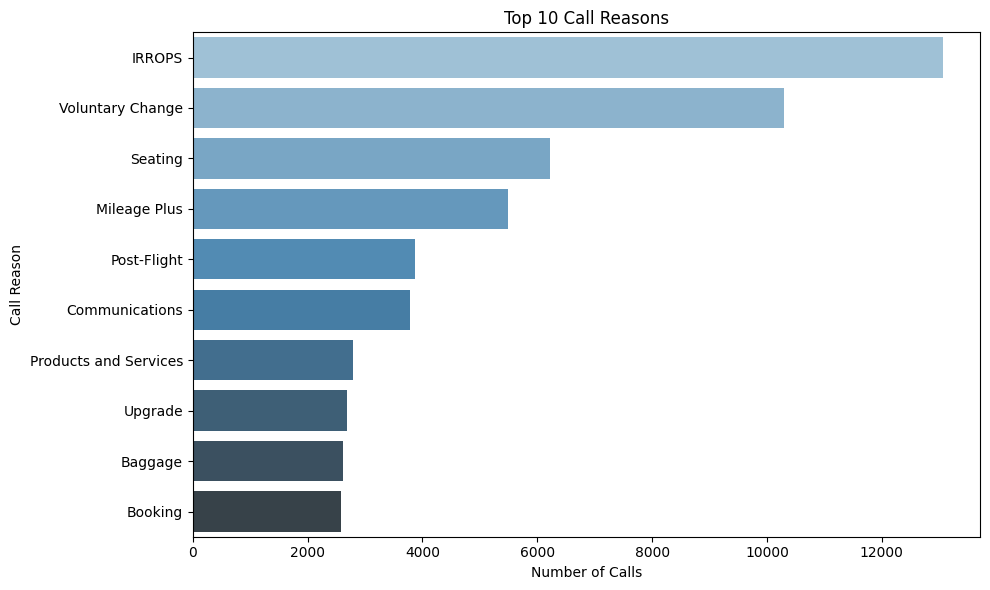

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF Vectorization for Transcripts
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
transcript_matrix = tfidf_vectorizer.fit_transform(df['call_transcript'])

# Topic Modeling using LDA (Latent Dirichlet Allocation)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(transcript_matrix)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}: " + ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tfidf_vectorizer.get_feature_names_out(), no_top_words)

# Frequency Analysis of Call Reasons
call_reason_counts = df['primary_call_reason'].value_counts()
print(call_reason_counts.head(10))

# Visualization of Frequent Call Reasons
plt.figure(figsize=(10, 6))
sns.barplot(x=call_reason_counts.values[:10], y=call_reason_counts.index[:10], palette="Blues_d")
plt.title('Top 10 Call Reasons')
plt.xlabel('Number of Calls')
plt.ylabel('Call Reason')
plt.tight_layout()
plt.show()

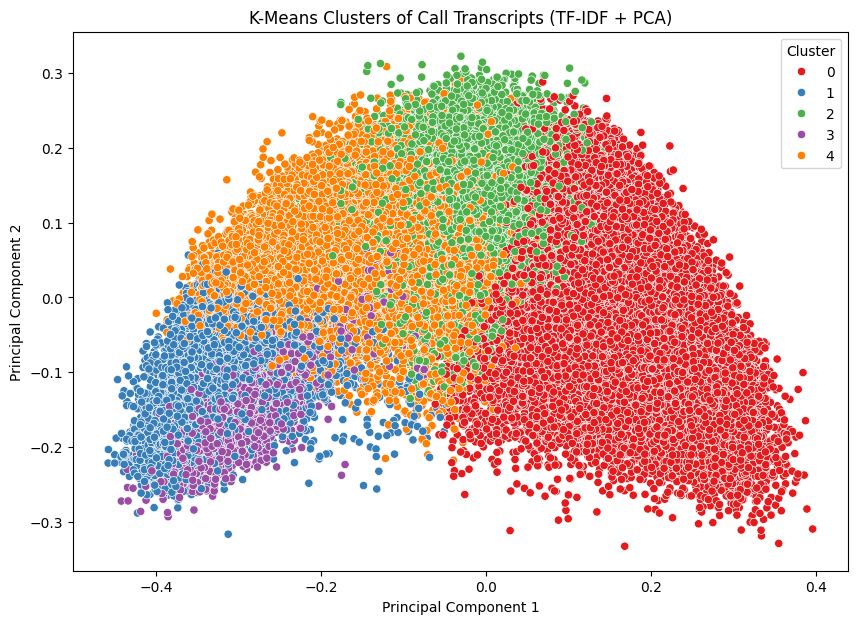

      call_id                                 cleaned_transcript  cluster
0  4667960400  \n\nagent: thank you for calling united airlin...        1
1  1122072124  \n\nagent: thank you for calling united airlin...        0
2  6834291559  \n\nagent: thank you for calling united airlin...        0
3  2266439882  \n\nagent: thank you for calling united airlin...        0
4  1211603231  \n\nagent: thank you for calling united airlin...        0
5  5297766997  \n\nagent: thank you for calling united airlin...        0
6   324593040  \n\nagent: thank you for calling united airlin...        4
7  8902603117  \n\nagent: thank you for calling united airlin...        4
8  7222687732  \n\nagent: thank you for calling united airlin...        2
9  4113684017  \n\nagent: thank you for calling united airlin...        3


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Preprocess the transcripts (cleaning text)
def preprocess_text(text):
    # Convert text to lowercase, remove punctuation, numbers, and stopwords
    text = text.lower()
    # Additional text preprocessing steps can be added here
    return text
df['cleaned_transcript'] =df['call_transcript'].apply(preprocess_text)

# Step 3: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_transcript'])

# Step 4: K-Means Clustering
num_clusters = 5  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Assign clusters to the dataset
df['cluster'] = kmeans.labels_

# Step 5: Dimensionality Reduction using PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Create a dataframe for visualization
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['cluster'] = kmeans.labels_

# Step 6: Visualization of Clusters using PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='Set1', legend='full')
plt.title('K-Means Clusters of Call Transcripts (TF-IDF + PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Step 7: Output the cluster assignment for review
print(df[['call_id', 'cleaned_transcript', 'cluster']].head(10))

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the call transcripts
df['sentiment_score'] = df['call_transcript'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Check the sentiment of the first few rows
print(df[['call_transcript', 'sentiment_score']])

                                         call_transcript  sentiment_score
0      \n\nAgent: Thank you for calling United Airlin...           0.9957
1      \n\nAgent: Thank you for calling United Airlin...           0.9989
2      \n\nAgent: Thank you for calling United Airlin...           0.9989
3      \n\nAgent: Thank you for calling United Airlin...           0.9889
4      \n\nAgent: Thank you for calling United Airlin...           0.9992
...                                                  ...              ...
71805  \n\nAgent: Thank you for calling United Airlin...           0.9989
71806  \n\nAgent: Thank you for calling United Airlin...           0.9966
71807  \n\nAgent: Thank you for calling United Airlin...           0.9985
71808  \n\nAgent: Thank you for calling United Airlin...           0.9983
71809  \n\nAgent: Thank you for calling United Airlin...           0.9992

[71810 rows x 2 columns]


In [7]:
# Analyze primary call reasons
call_reason_counts = df['primary_call_reason'].value_counts()
print("Call Reason Counts:")
print(call_reason_counts)


Call Reason Counts:
primary_call_reason
IRROPS                     13057
Voluntary Change           10291
Seating                     6223
Mileage Plus                5487
Post-Flight                 3869
Communications              3779
Products and Services       2792
Upgrade                     2682
Baggage                     2616
Booking                     2589
Checkout                    1840
Check-In                    1490
Voluntary Cancel            1304
Digital Support              996
ETC                          930
Traveler Updates             772
Schedule Change              707
Other Topics                 568
Products & Services          476
Disability                   394
Check In                     385
Post Flight                  373
Voluntary  Cancel            278
IRROPS                       254
Other  Topics                234
Voluntary Change             208
Voluntary   Change           200
Voluntary  Change            149
Seating                      142
Dig

In [8]:
# Analyzing sentiment and tone
sentiment_vs_reason = df.groupby('primary_call_reason')['average_sentiment'].mean()
print("Average Sentiment by Call Reason:")
print(sentiment_vs_reason)

# Analyze agent and customer tone impact on sentiment
tone_vs_sentiment = df.groupby(['agent_tone', 'customer_tone'])['average_sentiment'].mean().unstack()
print("Tone vs Sentiment:")
print(tone_vs_sentiment)

# Check the effect of silence on average sentiment
silence_vs_sentiment = df.groupby(pd.cut(df['silence_percent_average'], bins=[0, 10, 20, 30, 40, 50, 100]))['average_sentiment'].mean()
print("Silence vs Sentiment:")
print(silence_vs_sentiment)

Average Sentiment by Call Reason:
primary_call_reason
 Baggage                  -0.022824
Baggage                   -0.018988
Baggage                   -0.031538
Booking                   -0.013252
Booking                   -0.019787
Check In                  -0.029506
Check-In                  -0.045723
Check-In                  -0.082069
Checkout                  -0.068874
Checkout                  -0.075000
Communications            -0.036694
Communications            -0.017705
Digital   Support         -0.036250
Digital  Support          -0.030267
Digital Support           -0.044864
Digital Support            0.014444
Disability                 0.036497
Disability                 0.003333
ETC                       -0.049139
ETC                       -0.057273
IRROPS                    -0.074181
IRROPS                    -0.068063
Mileage   Plus            -0.023643
Mileage  Plus             -0.032074
Mileage Plus              -0.027659
Mileage Plus              -0.011600
Other  Top

C:\Users\91873\AppData\Local\Temp\ipykernel_17784\134351052.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  silence_vs_sentiment = df.groupby(pd.cut(df['silence_percent_average'], bins=[0, 10, 20, 30, 40, 50, 100]))['average_sentiment'].mean()


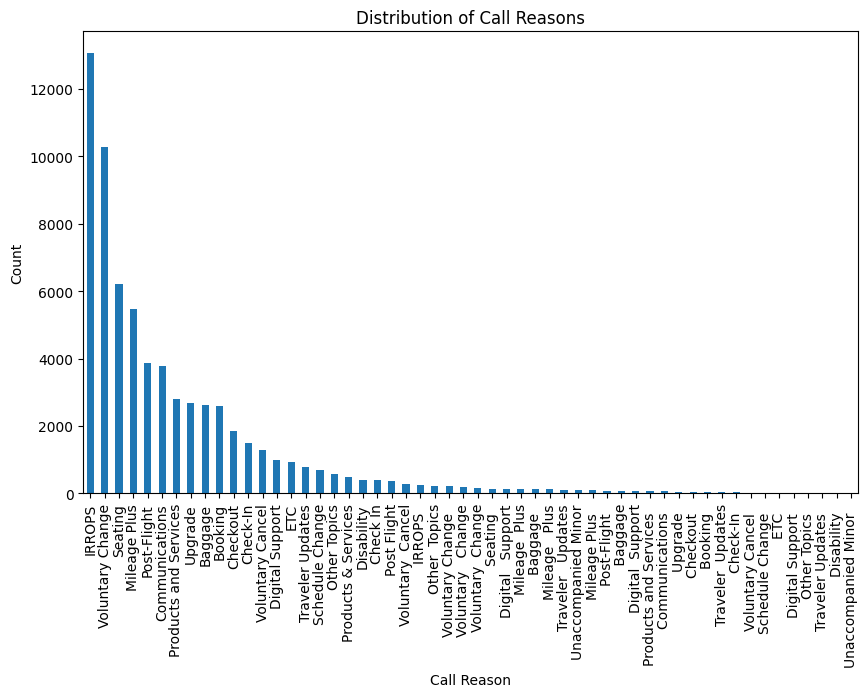

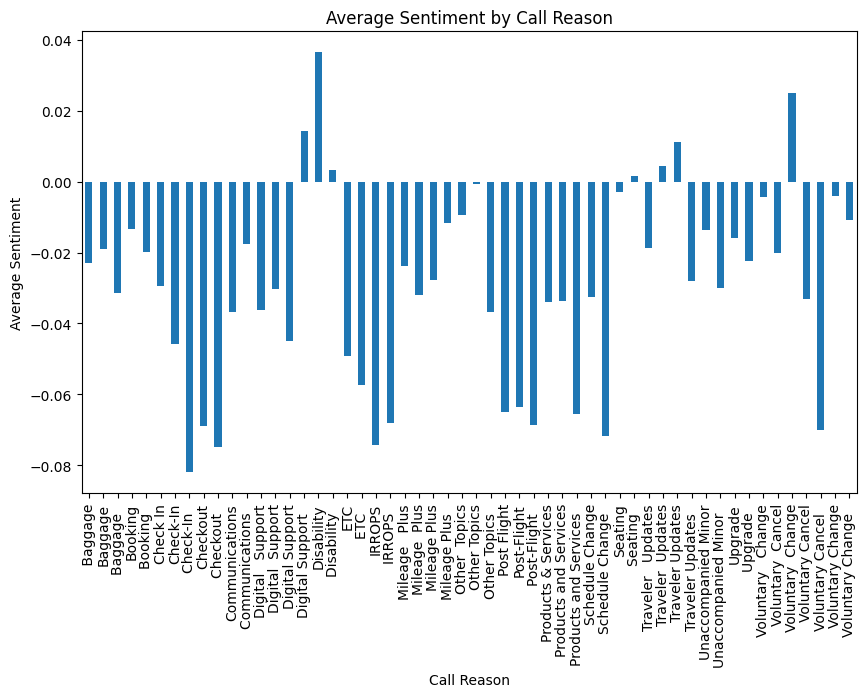

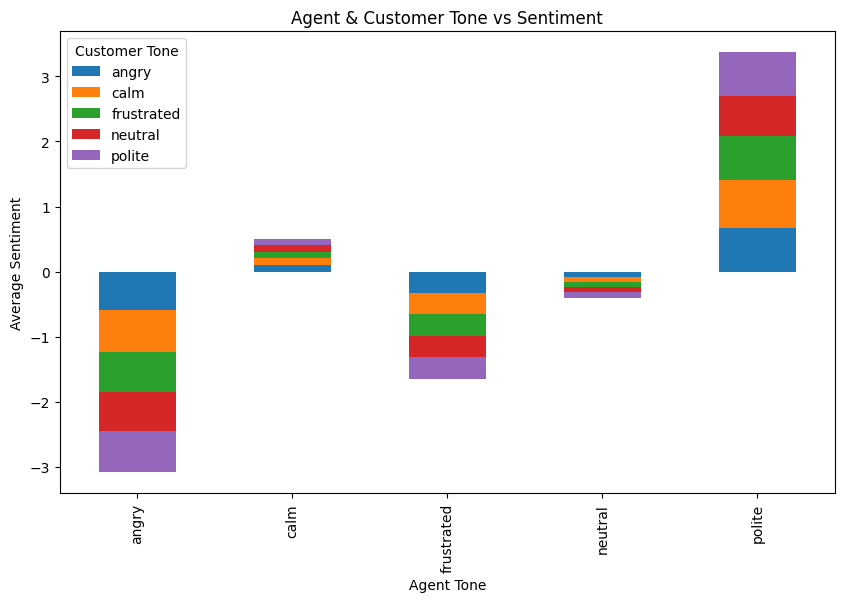

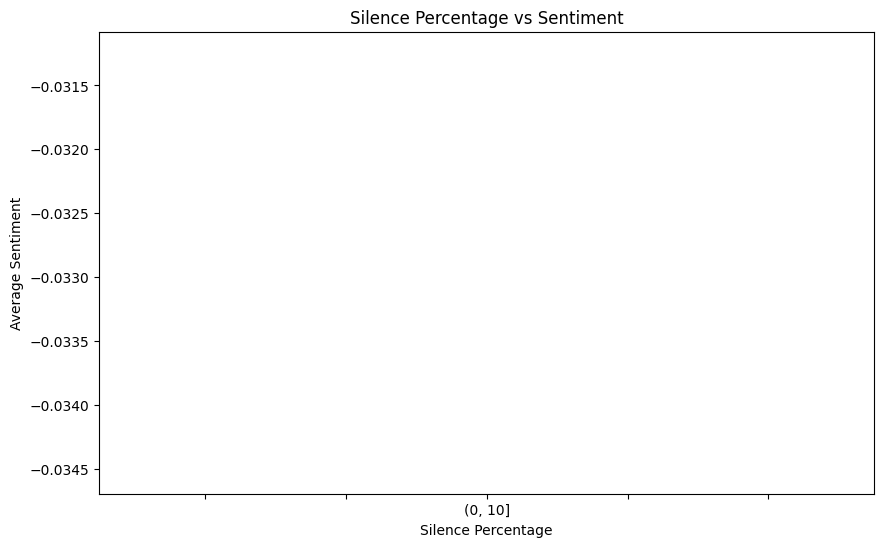

In [9]:
import matplotlib.pyplot as plt

# Plot the distribution of call reasons
call_reason_counts.plot(kind='bar', figsize=(10, 6))
plt.title("Distribution of Call Reasons")
plt.xlabel("Call Reason")
plt.ylabel("Count")
plt.show()

# Plot sentiment by call reason
sentiment_vs_reason.plot(kind='bar', figsize=(10, 6))
plt.title("Average Sentiment by Call Reason")
plt.xlabel("Call Reason")
plt.ylabel("Average Sentiment")
plt.show()

# Plot tone vs sentiment
tone_vs_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Agent & Customer Tone vs Sentiment")
plt.xlabel("Agent Tone")
plt.ylabel("Average Sentiment")
plt.legend(title="Customer Tone")
plt.show()

# Plot silence percentage vs sentiment
silence_vs_sentiment.plot(kind='line', figsize=(10, 6))
plt.title("Silence Percentage vs Sentiment")
plt.xlabel("Silence Percentage")
plt.ylabel("Average Sentiment")
plt.show()